In [1]:
import pickle
import warnings

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import numpy as np
import scipy
from evaluation import (
    energy_distance,  # noqa: F401
    eval_progressive_logreg,  # noqa: F401
    plot_progressive_results,  # noqa: F401
    test_accuracy,  # noqa: F401
    vec_dict_to_array,  # noqa: F401
)
from get_model import get_model_and_data  # noqa: F401
from main import run_simple_lmc_numpyro  # noqa: F401
from numpyro.infer import MCMC, NUTS, Predictive  # noqa: F401


%env JAX_PLATFORM_NAME=cuda
warnings.simplefilter("ignore", FutureWarning)

jnp.set_printoptions(precision=3, suppress=True)
jax.config.update("jax_enable_x64", True)
print(jax.devices("cuda"))

env: JAX_PLATFORM_NAME=cuda
[CudaDevice(id=0)]


In [5]:
dataset = scipy.io.loadmat("mcmc_data/benchmarks.mat")
data_name = "breast_cancer"
lmc_dict_filename = f"mcmc_data/{data_name}_lmc_dict.pkl"
nuts_dict_filename = f"mcmc_data/{data_name}_nuts_dict.pkl"
model_logreg, data_split = get_model_and_data(dataset, data_name)
x_train, labels_train, x_test, labels_test = data_split

num_particles = 2**15
x0 = Predictive(model_logreg, num_samples=num_particles)(
    jr.key(0), x_train, labels_train
)
del x0["obs"]

Data shape: (263, 9)
Shape of W: (9,), shape of b: (1,), shape of x: (210, 9)


In [6]:
gt_filename = f"mcmc_data/{data_name}_ground_truth.npy"

# gt_nuts = MCMC(
#     NUTS(model_logreg, step_size=1.0),
#     num_warmup=2**10,
#     num_samples=2**13,
#     num_chains=2**3,
#     chain_method="vectorized",
# )
# gt_nuts.run(jr.PRNGKey(0), x_train, labels_train)
# gt_logreg = vec_dict_to_array(gt_nuts.get_samples())
# np.save(gt_filename, gt_logreg)

gt_logreg = np.load(gt_filename)

Shape of W: (9,), shape of b: (1,), shape of x: (210, 9)
Shape of W: (9,), shape of b: (1,), shape of x: (210, 9)


  0%|          | 0/9216 [00:00<?, ?it/s]

Shape of W: (9,), shape of b: (1,), shape of x: (210, 9)


sample: 100%|██████████| 9216/9216 [00:31<00:00, 288.47it/s]


In [7]:
print(f"Ground truth shape: {gt_logreg.shape}")
size_gt_half = int(gt_logreg.shape[0] // 2)
energy_bias = energy_distance(gt_logreg[:size_gt_half], gt_logreg[size_gt_half:])
print(f"Energy bias: {energy_bias}")
print(f"test accuracy: {test_accuracy(x_test, labels_test, gt_logreg)}")
flattened_gt = jnp.reshape(gt_logreg, (-1, gt_logreg.shape[-1]))
print(flattened_gt.shape)
print(jnp.var(flattened_gt, axis=0))
print(jnp.mean(flattened_gt, axis=0))

Ground truth shape: (65536, 10)
Energy bias: 0.00013336307185185525
Shape of w: (1024, 9), shape of x: (9,)
test accuracy: (Array(0.662, dtype=float32), Array(0.667, dtype=float32))
(65536, 10)
[0.041 0.062 0.071 0.04  0.059 0.046 0.049 0.034 0.037 0.028]
[-1.25  -0.072  0.267  0.022  0.45  -0.197  0.734 -0.184 -0.008 -0.148]


In [11]:
out_lmc, steps_lmc = run_simple_lmc_numpyro(
    jr.key(0),
    model_logreg,
    (x_train, labels_train),
    num_particles,
    chain_len=2**5,
    chain_sep=1.0,
    tol=0.05,
)
print(jtu.tree_map(lambda x: x.shape, out_lmc))

100.00%|██████████| [00:16<00:00,  5.90%/s]

{'W': (32768, 32, 2), 'b': (32768, 32, 1)}


In [12]:
result_dict_lmc = eval_progressive_logreg(
    out_lmc, gt_logreg, steps_lmc, x_test, labels_test
)
with open(lmc_dict_filename, "wb") as f:
    pickle.dump(result_dict_lmc, f)

W2 computation took 1.3e+01 seconds


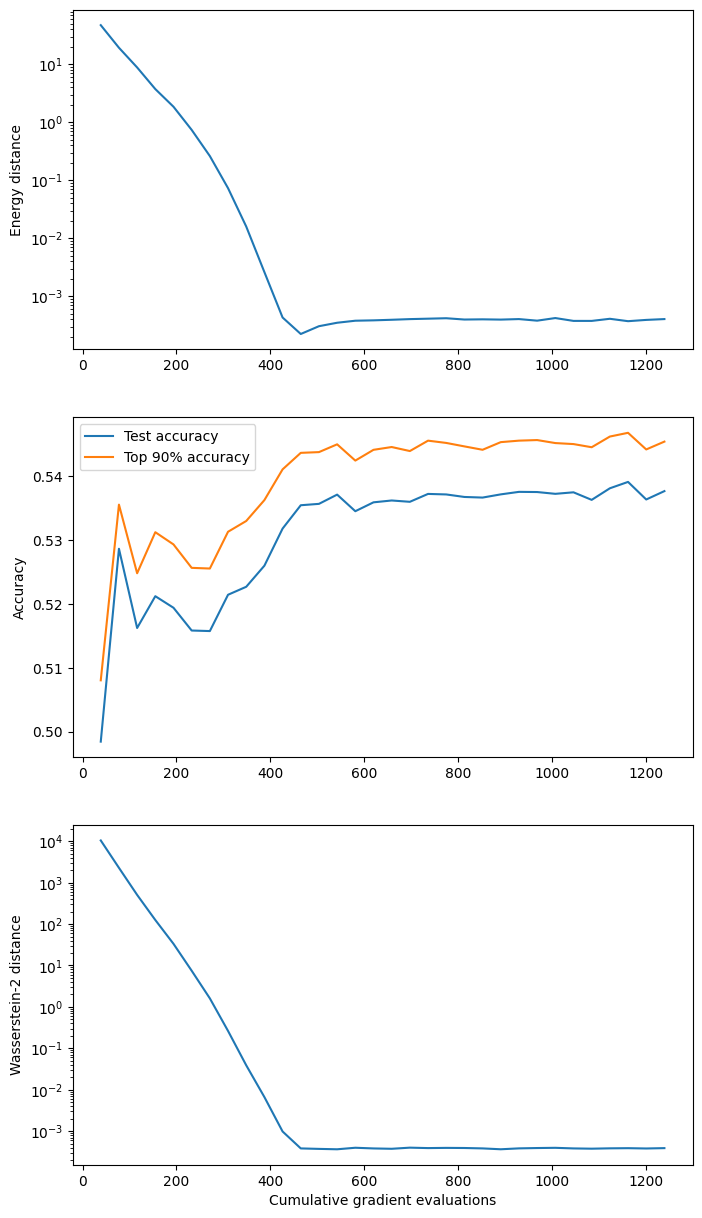

In [13]:
# load the dict
with open(lmc_dict_filename, "rb") as f:
    result_dict_lmc = pickle.load(f)
fig_lmc = plot_progressive_results(result_dict_lmc)
plt.show()

In [3]:
nuts_num_warmup = 20
chain_len_nuts = 2**7
nuts = MCMC(
    NUTS(model_logreg),
    num_warmup=nuts_num_warmup,
    num_samples=chain_len_nuts - nuts_num_warmup,
    num_chains=num_particles,
    chain_method="vectorized",
)
nuts.warmup(
    jr.PRNGKey(2),
    x_train,
    labels_train,
    init_params=x0,
    extra_fields=("num_steps",),
    collect_warmup=True,
)
warmup_steps = jnp.reshape(
    nuts.get_extra_fields()["num_steps"], (num_particles, nuts_num_warmup)
)
warmup_samples = nuts.get_samples(group_by_chain=True)
print(jtu.tree_map(lambda x: x.shape, warmup_samples))
nuts.run(jr.PRNGKey(0), x_train, labels_train, extra_fields=("num_steps",))
run_samples = nuts.get_samples(group_by_chain=True)
out_nuts = jtu.tree_map(
    lambda x, y: jnp.concatenate((x, y), axis=1), warmup_samples, run_samples
)
print(jtu.tree_map(lambda x: x.shape, out_nuts))
run_steps = jnp.reshape(nuts.get_extra_fields()["num_steps"], (num_particles, -1))
steps_nuts = jnp.concatenate((warmup_steps, run_steps), axis=-1)
steps_nuts = jnp.reshape(steps_nuts, (-1,))

warmup: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


{'W': (32768, 20, 2), 'b': (32768, 20, 1)}


sample: 100%|██████████| 108/108 [11:32<00:00,  6.41s/it]


{'W': (32768, 128, 2), 'b': (32768, 128, 1)}


In [4]:
print(jnp.mean(steps_nuts))

3.819627285003662


In [7]:
result_dict_nuts = eval_progressive_logreg(
    out_nuts,
    gt_logreg,
    steps_nuts,
    x_test,
    labels_test,
    metric_eval_interval=chain_len_nuts // (2**5),
    max_samples_w2=2**11,
)
with open(nuts_dict_filename, "wb") as f:
    pickle.dump(result_dict_nuts, f)

W2 computation took 1.5e+01 seconds


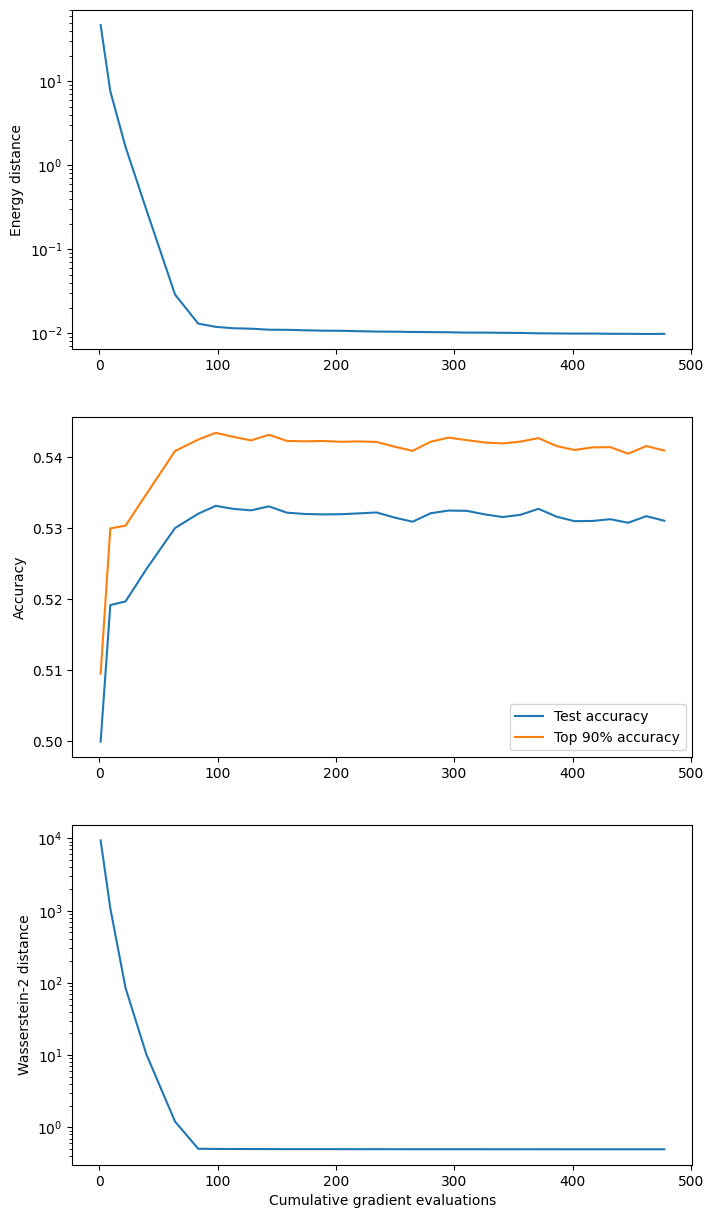

In [9]:
# load the dict
with open(nuts_dict_filename, "rb") as f:
    result_dict_nuts = pickle.load(f)
fig_nuts = plot_progressive_results(result_dict_nuts)
plt.show()